100%|██████████| 2000/2000 [01:24<00:00, 23.60it/s]


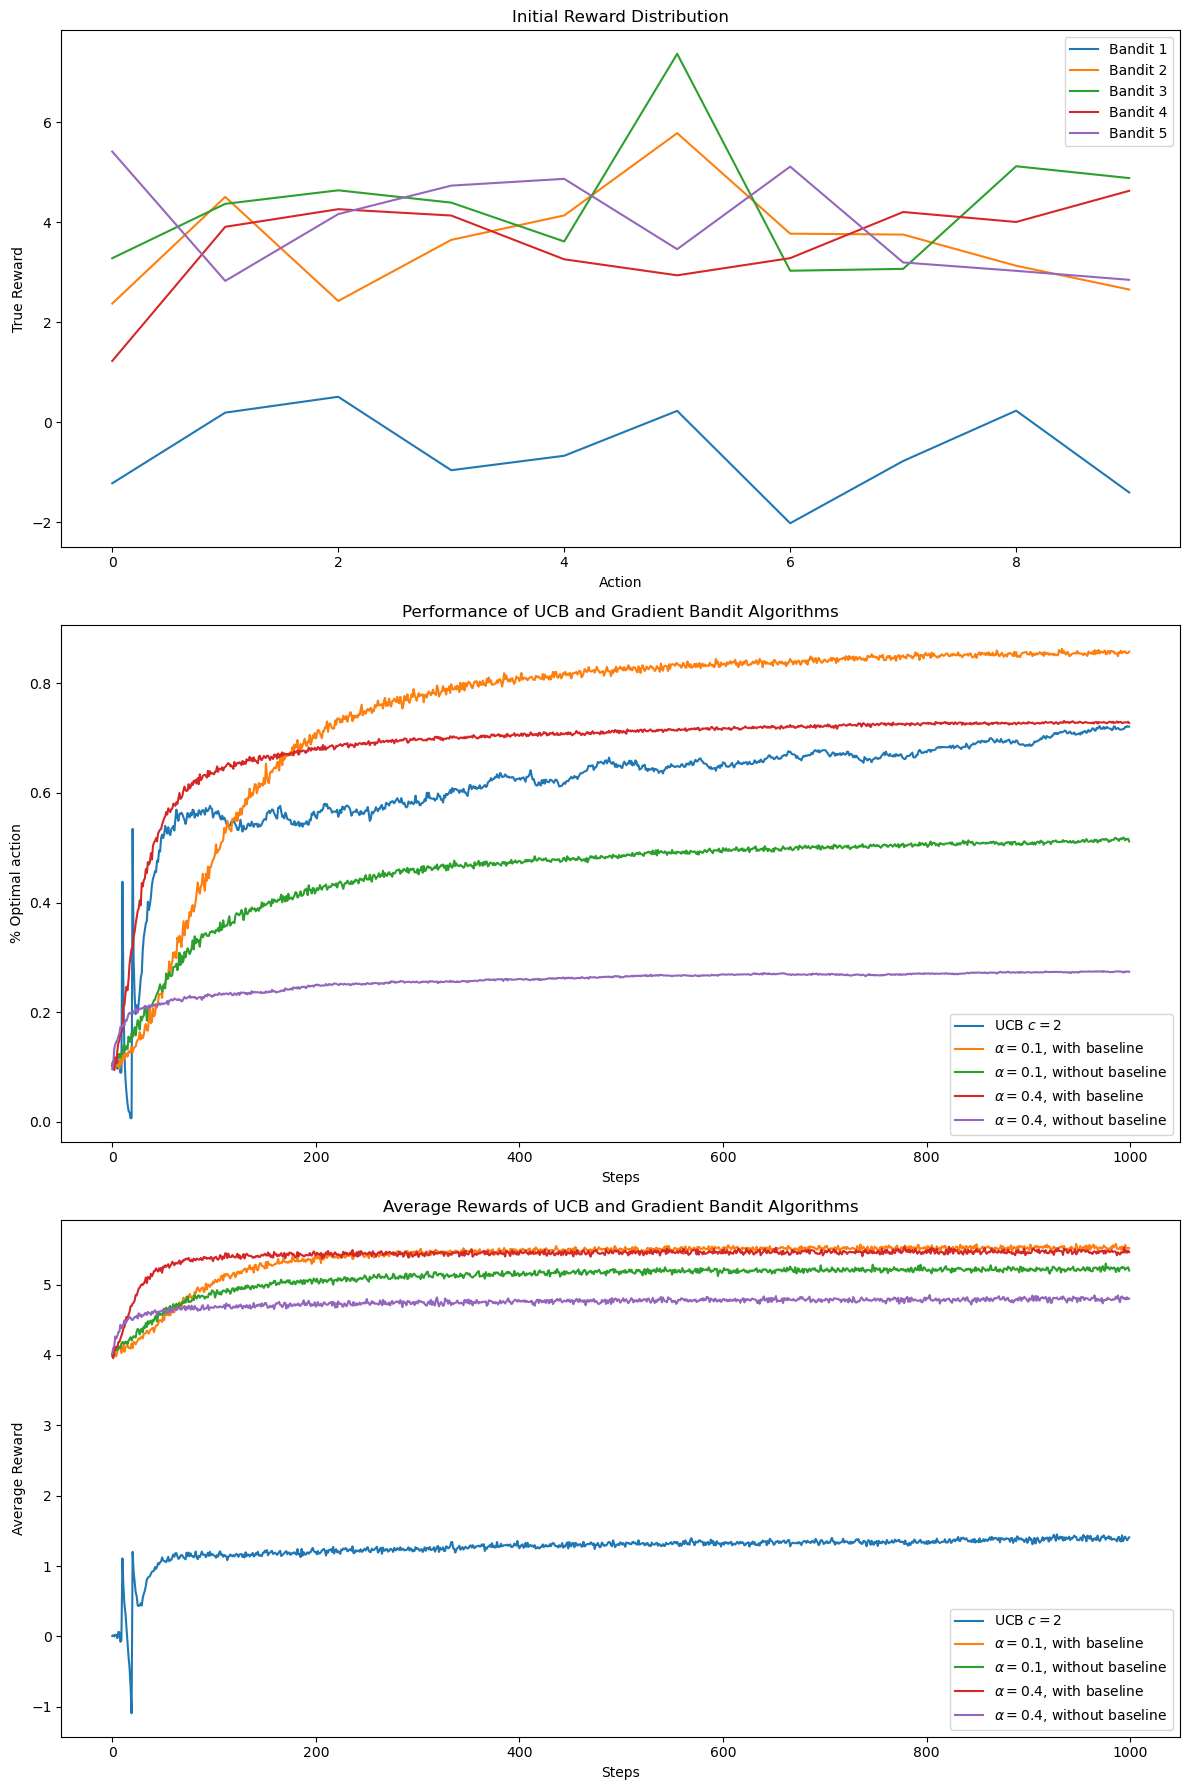

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

# 使用 Jupyter Notebook 的内嵌后端
%matplotlib inline

class Bandit:
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        self.q_true = np.random.randn(self.k) + self.true_reward
        self.q_estimation = np.zeros(self.k) + self.initial
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)
        self.time = 0

    def act(self):
        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            baseline = self.average_reward if self.gradient_baseline else 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward


def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards


def figure_UCB_vs_gradient(runs=2000, time=1000):
    bandits = [
        Bandit(epsilon=0, UCB_param=2, sample_averages=True),
        Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4),
        Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4),
        Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4),
        Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4)
    ]

    # 绘制结果
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # 绘制初始奖励分布
    for i, bandit in enumerate(bandits):
        bandit.reset()
        axs[0].plot(bandit.q_true, label=f'Bandit {i+1}')
    axs[0].set_xlabel('Action')
    axs[0].set_ylabel('True Reward')
    axs[0].set_title('Initial Reward Distribution')
    axs[0].legend()

    best_action_counts, average_rewards = simulate(runs, time, bandits)

    labels = ['UCB $c = 2$',
              r'$\alpha = 0.1$, with baseline',
              r'$\alpha = 0.1$, without baseline',
              r'$\alpha = 0.4$, with baseline',
              r'$\alpha = 0.4$, without baseline']

    # 绘制最佳动作百分比
    for i in range(len(bandits)):
        axs[1].plot(best_action_counts[i], label=labels[i])
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('% Optimal action')
    axs[1].set_title('Performance of UCB and Gradient Bandit Algorithms')
    axs[1].legend()

    # 绘制平均奖励
    for i in range(len(bandits)):
        axs[2].plot(average_rewards[i], label=labels[i])
    axs[2].set_xlabel('Steps')
    axs[2].set_ylabel('Average Reward')
    axs[2].set_title('Average Rewards of UCB and Gradient Bandit Algorithms')
    axs[2].legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    figure_UCB_vs_gradient()
